In [1]:
from zlib import crc32

In [2]:
crc32('грабовой'.lower().encode('utf-8'))%5+1, crc32('grabovoy'.lower().encode('utf-8'))%3+1

(2, 3)

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

from torch.utils.data import TensorDataset, DataLoader, Dataset

from torchvision import datasets

In [6]:
import pickle
# from google.colab import files

In [7]:
from tqdm import tqdm as tqdm

In [8]:
MNIST = datasets.MNIST('./mnist', train=False, download=True, transform=None)
X_test, Y_test = MNIST.test_data, MNIST.test_labels

MNIST = datasets.MNIST('./mnist', train=True, download=True, transform=None)
X_train, Y_train = MNIST.train_data, MNIST.train_labels

In [9]:
X_train = X_train.reshape([X_train.shape[0], -1]).float()
X_test = X_test.reshape([X_test.shape[0], -1]).float()

In [10]:
X_train.shape, X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

# Model

In [11]:
##########################################
# https://github.com/mariogeiger/hessian #
##########################################
#                                        #
# Данные функции были взяты из интернета #
#                                        #
##########################################

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

### Определим модель логистической регресии

In [12]:
class LogReg(nn.Module):
    def __init__(self, input_dim = 20, output_dim = 10, device = 'cpu'):
        super(LogReg, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(input_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        out = input
        out = F.relu(out)
        return self.linear(out)

# Training function

### Определим все функции для обучения модели

In [13]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
        model.zero_grad()
        
        output = model(batch_of_x)
        
        loss = loss_function(output, batch_of_y)
        loss.backward()
        optimizer.step()
     
        return
    
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)

    return

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            progress = None
           ):
    iterations = range(count_of_epoch)
    if progress is not None:
        iterations = progress(iterations)

    for it in iterations:
        optima = optimizer

        batch_generator = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima)
    
    return

# Переопределеный оптимизатор

Переопределим оптимизатор, чтобы оптимизировать только те переменые, которые не были удалены из модели

In [14]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            
# ==================================================
# Additition function
    def get_masks(self, kind = 'prune'):
        list_of_mask = []
        LIST_prune = []
        mask_vector = None
        if kind == 'prune':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    LIST_prune.append(prune_vector)
        mask_vector = torch.cat(LIST_prune)
        return mask_vector

    def prune(self, amount = 0.1, method='random', **argv):
        if method == 'random':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    if int(amount*len(p_vector)) > 0:
                        prune_vector[torch.randperm(p_vector.shape[0])[:int(amount*len(p_vector))]] = 0
                        p_vector.data.mul_(prune_vector)

        elif method == 'OBD':
            if argv['hessian'] is None:
                pass
            else:
                for group in self.param_groups:
                    for p, h in zip(group['params'], argv['hessian']):
                        param_state = self.state[p]
                        if 'prune' not in param_state:
                            param_state['prune'] = torch.ones_like(p)

                        p_vector = p.view(-1)
                        score = (p*h).view(-1)
                        prune_vector = param_state['prune'].view(-1)
                        if int(amount*len(p_vector)) > 0:
                            prune_vector[torch.sort(score)[1][:int(amount*len(p_vector))]] = 0
                            p_vector.data.mul_(prune_vector)

            pass
    
    def deprune(self):
        for group in self.param_groups:
             for p in group['params']:
                param_state = self.state[p]
                param_state['prune'] = torch.ones_like(p)
# ==================================================

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
# ==================================================
# Addition in each step
                d_p = p.grad.data.detach()
                param_state = self.state[p]
    
                if 'prune' in param_state:
                    prune = param_state['prune']
                else:
                    prune = torch.ones_like(p)
                    param_state['prune'] = prune
# ==================================================                   
                    
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                # Exponential moving average of gradient values
                if 'exp_avg' not in state:
                    state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                if 'exp_avg_sq' not in state:
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    if 'max_exp_avg_sq' not in state:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                    
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2**(0.5)) / bias_correction1

                p.data.addcdiv_(-step_size, prune*exp_avg, denom)

        return loss

# Training

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
loss_function = torch.nn.CrossEntropyLoss()

In [17]:
TRAIN = TensorDataset(X_train.to(device), Y_train.to(device))
TEST = TensorDataset(X_test.to(device), Y_test.to(device))

In [18]:
model = LogReg(input_dim=X_train.shape[1], output_dim = 10, device=device)

In [19]:
optimizer = Adam(model.parameters())

In [20]:
# trainer(count_of_epoch = 100,
#         batch_size = 64,
#         dataset = TRAIN,
#         model = model,
#         loss_function = loss_function,
#         optimizer = optimizer,
#         progress = tqdm
#        )

In [21]:
# torch.save(model.state_dict(), 'train_model.sv')

In [22]:
output = model(TRAIN[:][0])

loss = loss_function(output, TRAIN[:][1])

In [23]:
def resize_hess(model, hess):
    bias = 0
    new_hess = []
    for p in model.parameters():
        p_size = torch.tensor(p.size()).prod()
        new_hess.append(hess[bias:bias+p_size].view_as(p))
        bias+=p_size
    return new_hess

In [24]:
# %%time
# hess = hessian(loss, model.parameters())

# hhs = torch.diag(hess)
# hs = resize_hess(model, hhs)

In [25]:
# with open('hess.pkl', 'wb') as f:
#     pickle.dump(hs, f)

with open('dump/hess.pkl', 'rb') as f:
    hs = pickle.load(f)

In [26]:
# files.download('train_model.sv')
# files.download('hess.pkl')

In [27]:
amounts = np.linspace(0, 1, 10)
k_for_averaging = 5

List_of_random_score = []
for amount in tqdm(amounts):
    List_of_score = []
    for _ in range(k_for_averaging):
        model.load_state_dict(torch.load('dump/train_model.sv'))
        optimizer = Adam(model.parameters())
        optimizer.prune(amount=amount, method='random', hessian=hs)

        trainer(count_of_epoch = 2,
            batch_size = 64,
            dataset = TRAIN,
            model = model,
            loss_function = loss_function,
            optimizer = optimizer
        )

        output = model(TEST[:][0])
        output.sum(dim = 1)
        answ = torch.argmax(torch.softmax(output, dim = 1), dim = 1)

        List_of_score.append(float((TEST[:][1] == answ).sum())/TEST[:][1].shape[0])
    List_of_random_score.append(List_of_score)
  
List_of_random_score = np.array(List_of_random_score)


List_of_OBD_score = []
for amount in tqdm(amounts):
    model.load_state_dict(torch.load('dump/train_model.sv'))
    optimizer = Adam(model.parameters())
    optimizer.prune(amount=amount, method='OBD', hessian=hs)

    trainer(count_of_epoch = 2,
        batch_size = 64,
        dataset = TRAIN,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer
    )

    output = model(TEST[:][0])
    output.sum(dim = 1)
    answ = torch.argmax(torch.softmax(output, dim = 1), dim = 1)

    List_of_OBD_score.append(float((TEST[:][1] == answ).sum())/TEST[:][1].shape[0])
  
List_of_OBD_score = np.array(List_of_OBD_score)

100%|██████████| 10/10 [00:23<00:00,  2.28s/it]


In [28]:
random_mean = np.mean(List_of_random_score, axis = 1)
random_std = np.std(List_of_random_score, axis = 1)

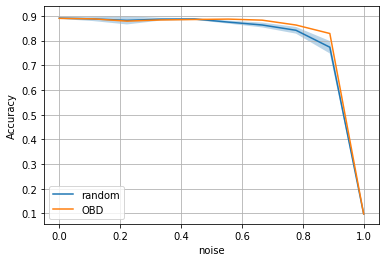

In [32]:
plt.plot(amounts, random_mean, label='random')
plt.fill_between(amounts, random_mean-random_std, random_mean+random_std, alpha=0.3)

plt.plot(amounts, List_of_OBD_score, label='OBD')

plt.legend(loc='best')
plt.grid()

plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

# Вывод

Метод Optimal Brain Damage позволяет удалять больше параметров (около 80% против окола 70%) без значимой потери точности. Следовательно данный метод является намного лучше чем произвольное удаление параметров.

Стоит заметить, что произвольное удаление параметров также позволяет удалять большое количество параметров из модели, это связано с тем, что большое количество точек в картиинках mnist это фон (значит данный признак нулевой). И все точки из границы изображения являются не нужными, что и позволяет убрать большое количество признаков.